<a href="https://colab.research.google.com/github/NikolayWTF/Building_a_GPT/blob/main/EseninLLM_with_RMSNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

Загружаю датасет. Не предобработаный.

In [ ]:
!gdown 1QSkQrVLv-sshOYlnPMMyh-ooGbAQ_pr4

Downloading...
From: https://drive.google.com/uc?id=1QSkQrVLv-sshOYlnPMMyh-ooGbAQ_pr4
To: /content/esenin.txt
100% 158k/158k [00:00<00:00, 84.9MB/s]


Делаю предобработку текста

In [ ]:
!gdown 1n4KZsoH3XUYgtVCqQwV-lkVaj9n4Qu8T

Downloading...
From (original): https://drive.google.com/uc?id=1n4KZsoH3XUYgtVCqQwV-lkVaj9n4Qu8T
From (redirected): https://drive.google.com/uc?id=1n4KZsoH3XUYgtVCqQwV-lkVaj9n4Qu8T&confirm=t&uuid=2a292668-fa36-46a8-b6eb-c0c09c751ac5
To: /content/preprocessing.py
100% 2.41k/2.41k [00:00<00:00, 11.8MB/s]


In [ ]:
!python preprocessing.py

# Изменяю нормализацию
1. Заменю LayerNorm на RMSNorm
2. Пробую нормализацию NormFormer

## RMSNorm

In [ ]:
import torch.nn as nn
import torch

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # x: (B, T, C)
        rms = x.pow(2).mean(dim=-1, keepdim=True).sqrt()
        x_normed = x / (rms + self.eps)
        return self.gamma * x_normed


## NormFormer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NormFormer(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        # Случайная инициализация весов и смещений для каждой нормализации
        self.gamma_1 = nn.Parameter(torch.ones(dim))
        self.beta_1 = nn.Parameter(torch.zeros(dim))
        self.gamma_2 = nn.Parameter(torch.ones(dim))
        self.beta_2 = nn.Parameter(torch.zeros(dim))

    def forward(self, x):

        if x.shape[1] <= 1:
            return x  # пропускаем нормализацию, иначе дисперсия = 0

        # x: (B, T, C)

        # Нормализация по первой оси (среднее и дисперсия)
        norm_1 = torch.mean(x, dim=-1, keepdim=True)
        x_1 = (x - norm_1) / torch.sqrt(torch.var(x, dim=-1, keepdim=True) + self.eps)

        # Нормализация по второй оси (среднее и дисперсия)
        norm_2 = torch.mean(x_1, dim=1, keepdim=True)
        x_2 = (x_1 - norm_2) / torch.sqrt(torch.var(x_1, dim=1, keepdim=True) + self.eps)

        # Применение весов и смещений
        return (self.gamma_1 * x_1 + self.beta_1) + (self.gamma_2 * x_2 + self.beta_2)



## Общий код

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # сколько последовательностей обрабатываем одновременно
block_size = 128 # контекст (максимальная длина входа). 128 - примерно 4 строки. Делаю такой размер чтобы модель попробовала уловить рифму
max_iters = 6000 # сколько шагов обучения
eval_interval = 100 # как часто считать loss на валидации
learning_rate = 6e-4 # скорость обучения
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200 # сколько батчей берём при оценке loss
n_embd = 128 # размерность эмбеддингов
n_head = 2 # количество голов в multi-head attention
n_layer = 2 # количество блоков трансформера
dropout = 0.0 # вероятность dropout
#---custom parametrs---
normalization_dict = {
    "LayerNorm": nn.LayerNorm(n_embd),
    "RMSNorm": nn.RMSNorm(n_embd),
    "NormFormer": NormFormer(n_embd)
    }
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('esenin_preprocessed.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text))) # уникальные символы
vocab_size = len(chars) # размер словаря
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) } # символ -> индекс
itos = { i:ch for i,ch in enumerate(chars) } # индекс -> символ
encode = lambda s: [stoi[c] for c in s] # строка -> индексы
decode = lambda l: ''.join([itos[i] for i in l]) # индексы -> строка

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Функция создает один обучающий/валидационный батч. Она вернёт 2 тензора: входы x и цели y
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """Transformer block with actual Pre-Norm"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.ln1 = normalization_dict[normalization_type]
        self.ln2 = normalization_dict[normalization_type]
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)

    def forward(self, x):
        # Pre-Norm: LN -> SubLayer -> Add
        x = self.sa(self.ln1(x)) + x
        x = self.ffwd(self.ln2(x)) + x
        return x



# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = normalization_dict[normalization_type]
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            assert targets.min() >= 0, f"Invalid target: {targets.min()}"
            assert targets.max() < vocab_size, f"Invalid target: {targets.max()} >= vocab_size {vocab_size}"
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply temperature scaling
            logits = logits / temperature
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:
plot_dict = {
    "LayerNorm": {
        "iter": [],
        "train": [],
        "val": []
    },
    "RMSNorm": {
        "iter": [],
        "train": [],
        "val": []
    },
    "NormFormer": {
        "iter": [],
        "train": [],
        "val": []
    },
}

In [ ]:
def plot_loss(normalization_type):

  iter_list = plot_dict[normalization_type]["iter"].copy()
  train_loss = plot_dict[normalization_type]["train"].copy()
  val_loss = plot_dict[normalization_type]["val"].copy()

  plt.figure(figsize=(12, 6))

  plt.plot(iter_list, train_loss, label='Train Loss', color='#1f77b4', marker='o', linewidth=2)
  plt.plot(iter_list, val_loss, label='Validation Loss', color='#ff7f0e', marker='s', linewidth=2)

  #plt.yscale('log')
  plt.xlabel('Итерации', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.title(f'Обучение с нормализацией = {normalization_type}', fontsize=14)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)
  plt.legend(fontsize=12)
  plt.tight_layout()
  plt.show()


In [ ]:
def generate_text(model):
  start_texts = [
    "Когда я был молод\n",
    "Я влюблён в тебя Ирина\n",
    "Вот уж вечер. Роса\n",
    "Вот уж вечер. Роса\nБлестит на крапиве.\nЯ стою у дороги,\nПрислонившись к иве.\nОт луны свет большой\nПрямо на нашу крышу.\nГде-то песнь соловья\nВдалеке я слышу.\nХорошо и тепло,\nКак зимой у печки.\nИ березы стоят,\nКак большие свечки.\nИ вдали за рекой,\nВидно, за опушкой,\n"
    ]
  print("-"*50)
  for start_text in start_texts:
    context = torch.tensor(encode(start_text), dtype=torch.long, device=device).unsqueeze(0)
    generated_text = decode(model.generate(context, max_new_tokens=500)[0].tolist())
    print(generated_text)
    print("-"*50)

## Запуск LayerNorm

In [ ]:
normalization_type = "LayerNorm"
max_iters = 2300
eval_interval = 100
block_size = 256

In [ ]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

iter_list = []
train_loss = []
val_loss = []
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        iter_list.append(iter)
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_dict[normalization_type]["iter"] = iter_list.copy()
plot_dict[normalization_type]["train"] = train_loss.copy()
plot_dict[normalization_type]["val"] = val_loss.copy()

0.446023 M parameters
step 0: train loss 5.1601, val loss 5.1601
step 100: train loss 2.6597, val loss 2.6900
step 200: train loss 2.6063, val loss 2.6403
step 300: train loss 2.5897, val loss 2.6172
step 400: train loss 2.5805, val loss 2.6122
step 500: train loss 2.5737, val loss 2.6049
step 600: train loss 2.5696, val loss 2.5957
step 700: train loss 2.5639, val loss 2.5939
step 800: train loss 2.5517, val loss 2.5828
step 900: train loss 2.5476, val loss 2.5727
step 1000: train loss 2.5248, val loss 2.5554
step 1100: train loss 2.4967, val loss 2.5276
step 1200: train loss 2.4446, val loss 2.4802
step 1300: train loss 2.3805, val loss 2.4190
step 1400: train loss 2.3225, val loss 2.3708
step 1500: train loss 2.2574, val loss 2.3055
step 1600: train loss 2.2039, val loss 2.2605
step 1700: train loss 2.1649, val loss 2.2288
step 1800: train loss 2.1169, val loss 2.1864
step 1900: train loss 2.0906, val loss 2.1642
step 2000: train loss 2.0446, val loss 2.1281
step 2100: train loss 2.

In [ ]:
generate_text(model)


--------------------------------------------------
Когда я был молод
Вот твою вередь..
Толно мне не краскушкою,-смираиность,
Ой, где целось гдтом крупо я покть
Лью ножы с бегу цветчу не бемное судь!

Я от бропытя в после нема,
Чудись горздвом груд местанне уста.
Взрьыный я прозарит мосты.
В дорога, тизагут обено,
Вегорат сканкин зыбей чт убка
На на витрать.

У любицводоматьлитсенную,
Густая вешь сту та сине.
И стою
Гола взделаю
Векимать схот мень загой том.
РозораздыТысьсял сдь на баздых торасную
И магли мой
Жареватыже мрань.
И годеся дь огряд ме,
Вишь сено! пока
--------------------------------------------------
Я влюблён в тебя Ирина
Рож прою твоня, гуят
Бежеска! Божирафрой жишье не в песник.
Не живы в С.А. Тьмась, непать какаколь, над кодя встал.
И постал Мно, в богни холос идался,
Стушоселых на зых тебере,
Побовала коленным яж убипокник.
Руди дом звеня тогой,
Иголаве па..
Торе -
Я месят конадиныет заворинаха.
Вмогосты-т, тених менсом в дати дорам
Нушув верым!
Ты инаду щук втень щен

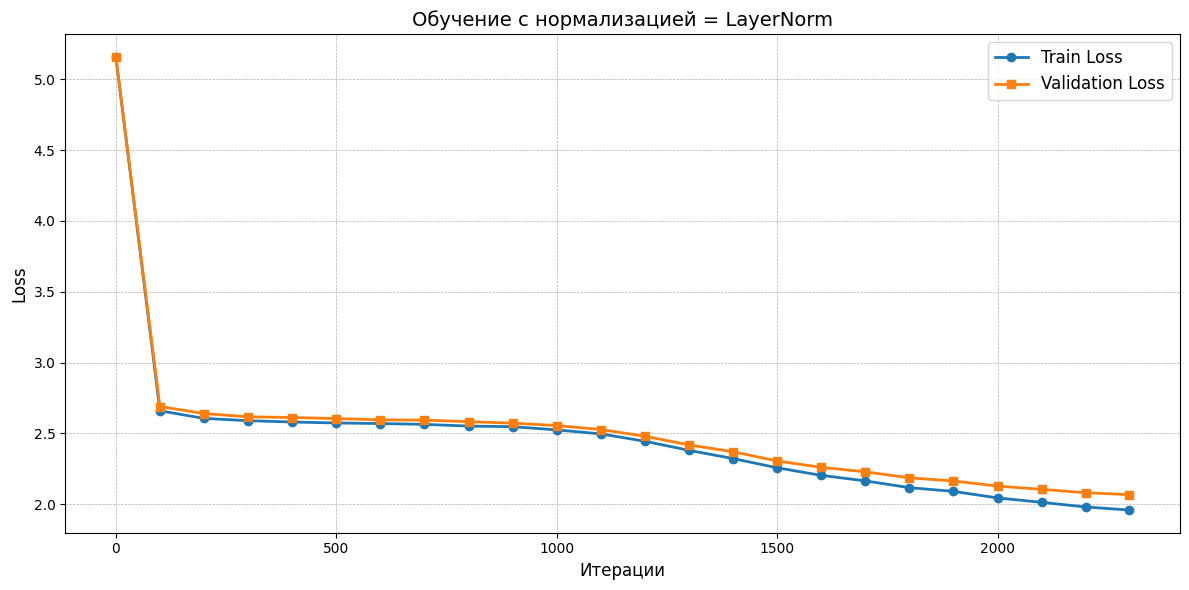

In [ ]:
plot_loss(normalization_type)

In [ ]:
LayerNormModel = model

In [ ]:
print(logits.mean().item(), logits.std().item())

-1.5687291622161865 3.589998960494995


## Запуск RMSNorm

In [ ]:
normalization_type = "RMSNorm"
max_iters = 8000
eval_interval = 100
block_size = 16

In [ ]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

iter_list = []
train_loss = []
val_loss = []
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        iter_list.append(iter)
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_dict[normalization_type]["iter"] = iter_list.copy()
plot_dict[normalization_type]["train"] = train_loss.copy()
plot_dict[normalization_type]["val"] = val_loss.copy()

0.415175 M parameters
step 0: train loss 4.6211, val loss 4.6012
step 100: train loss 2.6952, val loss 2.7247
step 200: train loss 2.5887, val loss 2.6115
step 300: train loss 2.5202, val loss 2.5525
step 400: train loss 2.4627, val loss 2.4906
step 500: train loss 2.4256, val loss 2.4646
step 600: train loss 2.4077, val loss 2.4317
step 700: train loss 2.3747, val loss 2.4058
step 800: train loss 2.3475, val loss 2.3955
step 900: train loss 2.3251, val loss 2.3660
step 1000: train loss 2.2988, val loss 2.3424
step 1100: train loss 2.2727, val loss 2.3147
step 1200: train loss 2.2584, val loss 2.3010
step 1300: train loss 2.2478, val loss 2.2795
step 1400: train loss 2.2424, val loss 2.2807
step 1500: train loss 2.2054, val loss 2.2641
step 1600: train loss 2.2029, val loss 2.2450
step 1700: train loss 2.2011, val loss 2.2396
step 1800: train loss 2.1757, val loss 2.2256
step 1900: train loss 2.1691, val loss 2.2293
step 2000: train loss 2.1606, val loss 2.2282
step 2100: train loss 2.

In [ ]:
generate_text(model)

--------------------------------------------------
Когда я был молод
Голят то довор, и не я, семе
Напах безумня не надо.

Весерой луны часой:
Те с на любить ты и долиганны.
Пуйных лугам
Заганится твой платок.
Я монаном я твой.
Коловочкогда-той, что мне раслет вот
Ещах упахнные знакогда и скасам высить
Киным над зеленых.
Навсем: зносты селать, мой водью к ольцо да вечеду.
Только ни жали: "Я поуть?-Не распись в розы легко сторона ты
В кутся по углу.
У Шапаря
Мене дубромо я дол.
Стиховый кудр познихин спросад бирака:

Потому любись любим, я роши вьются и дальна
Буди
--------------------------------------------------
Я влюблён в тебя Ирина
Из уетрадетем
Только бы похленные грива!
П!ю.
Я правда моная отчий, сужимам,
Мне привесь не страну.
Сол.
Я пой душу лов".
Ведь в грустю. Я извонком
Навсе белись одна поля
И пекрасивый раз окошка рощи я розовую
На завишки плесось.
Я мощи. Я одна, как сендались сысок в миртый солов,
Баганэ!...
Весной рядий нежно за кудеС.А. Т хует рань
Мне раская выплеть,


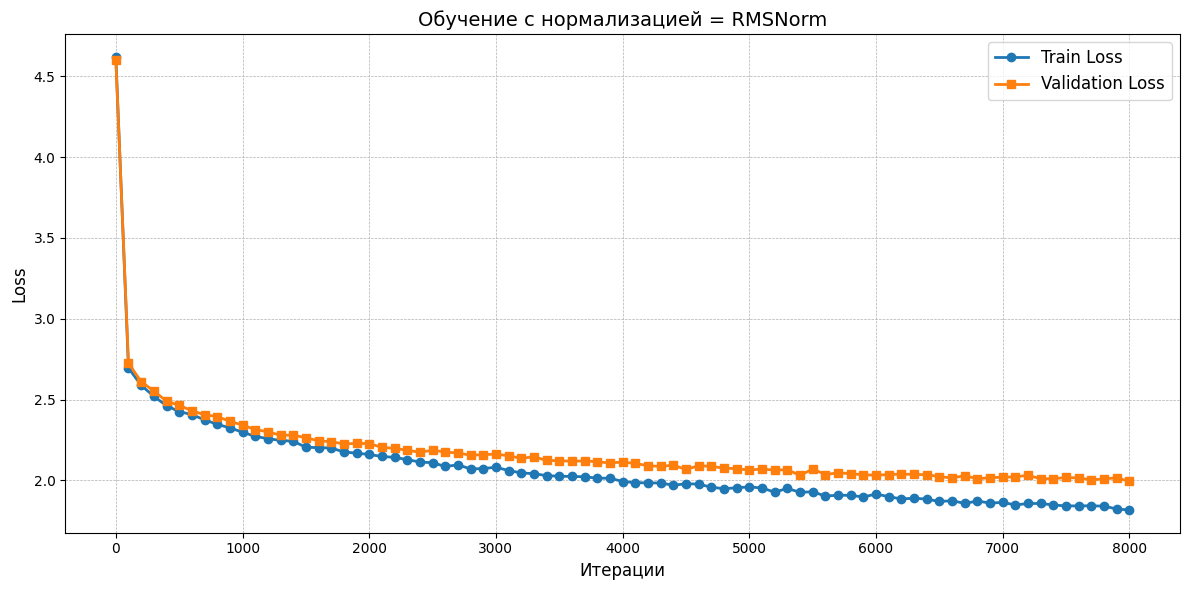

In [ ]:
plot_loss(normalization_type)

## Запуск NormFormer

In [ ]:
normalization_type = "NormFormer"
max_iters = 2000
eval_interval = 100
block_size = 32

In [ ]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

iter_list = []
train_loss = []
val_loss = []
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, delta {(losses['val'] - losses['train']):.4f}")
        iter_list.append(iter)
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_dict[normalization_type]["iter"] = iter_list.copy()
plot_dict[normalization_type]["train"] = train_loss.copy()
plot_dict[normalization_type]["val"] = val_loss.copy()

0.417607 M parameters
step 0: train loss 4.9746, val loss 4.9823, delta 0.0077
step 100: train loss 2.5285, val loss 2.5537, delta 0.0253
step 200: train loss 2.2517, val loss 2.2881, delta 0.0364
step 300: train loss 1.8826, val loss 1.9021, delta 0.0196
step 400: train loss 1.4420, val loss 1.4840, delta 0.0420
step 500: train loss 1.1095, val loss 1.1365, delta 0.0270
step 600: train loss 0.8899, val loss 0.9291, delta 0.0392
step 700: train loss 0.7419, val loss 0.7694, delta 0.0274
step 800: train loss 0.6506, val loss 0.6770, delta 0.0264
step 900: train loss 0.5441, val loss 0.5737, delta 0.0296
step 1000: train loss 0.4940, val loss 0.5151, delta 0.0211
step 1100: train loss 0.4333, val loss 0.4576, delta 0.0243
step 1200: train loss 0.3939, val loss 0.4214, delta 0.0276
step 1300: train loss 0.3560, val loss 0.3825, delta 0.0265
step 1400: train loss 0.3460, val loss 0.3673, delta 0.0214
step 1500: train loss 0.3189, val loss 0.3468, delta 0.0280
step 1600: train loss 0.2903, 

Тестирование на текстовой генерации

In [ ]:
generate_text(model)

--------------------------------------------------
Когда я был молод
В счусеселсесем нать визаясвке смой пествя брой ло ной.
Чаткирой бный горапой,
Ка илякротая ный гойакь
й
Висименкатжняютем чи млибапнета нтечтай
К.
Отя пумипладитмит томольямуторал,
Нойинат
я гумий кушь римный литьсноной
Лить чутвеныхизвоморугить.
Ототвний тоны,
Жирыладиокин доёурогорорью
Тохновий ратя учжникопу
На
К, го вмныпяна хой ая.
Опроч тБоя в пай.
Хони, исатбо,бе,ньет омомя гжульбому
РыАлстькит
ОбнийСшья чутьрочньюнойов мелуталныхоскустяси чушь,
му жкитсть за л нетдыталющусть кчугодро на
--------------------------------------------------
Я влюблён в тебя Ирина
В ом оедь усхалороня,
Пучий огаярт кару дом
Нам, кохадит внывьннатдяю,
Хонят зачуны ю та лумныйся,
хноль чкат инаюзаледни к,
Во
Налья калянгустськ скойсьепем,
О никугк ляны вой изухни,
ОнСма светкудиныт бон
З кожески,итойсох лыокои, подыпениелсинытречтоаконогольнитьез мошь с Болетнутьстоли хочули мостаноту.
Польцеткони килихопрали хукитымук чакилюак зали

График

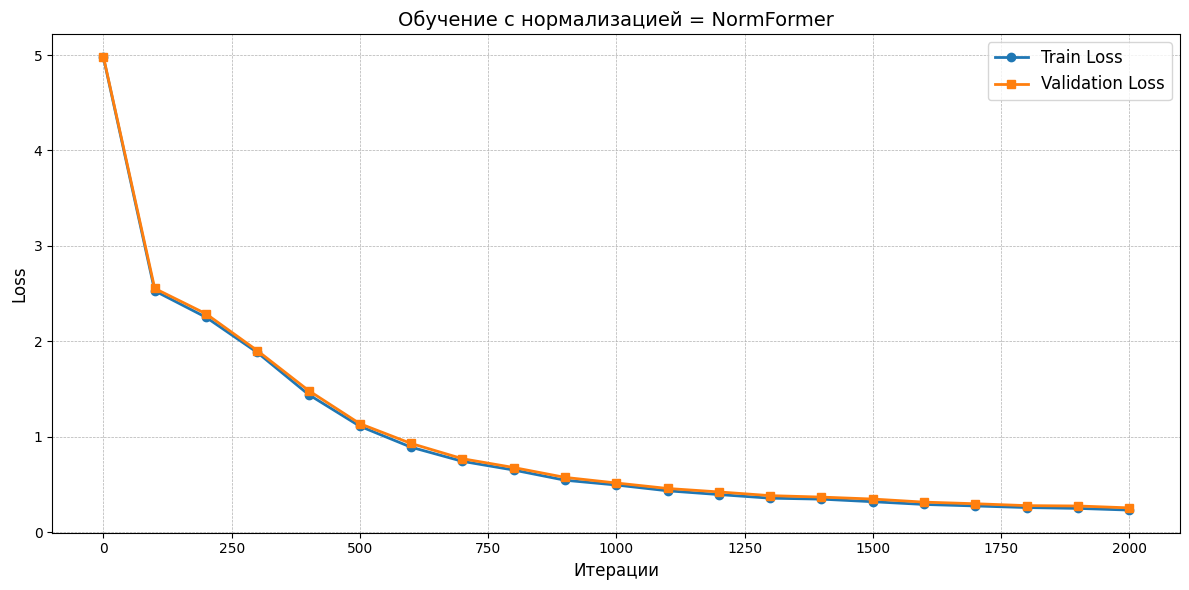

In [ ]:
plot_loss(normalization_type)

In [ ]:
print(logits.mean().item(), logits.std().item())

-0.8663421869277954 3.7220771312713623


In [ ]:
NormFormerModel = model